# Network Builder
This notebook is a step by step in building a heterogeneous graph for our dataset recommendation system. The step by step is in effort to make our graph more well connected, which will be as follows:
1. Load train_test data
2. Load Phase 1 & Phase 2 competition output data
3. Combine data from step 1 & step 2
4. Generate initial graph of `[publication, dataset]` entities
5. Extract & Integrate `Subject Terms` Entity
6. Load & Integrate `Author` Entity
7. Load & Integrate Publication Similarity Edges

In [2]:
import json 
import itertools
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.readwrite import json_graph

def writeNX(filename, g):
    network_json = json_graph.node_link_data(g)
    json.dump(network_json, open(filename, 'w'), indent=2)
def readNX(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

%matplotlib inline

# 1. Load train_test data

In [3]:
tt_pub = pd.read_json('data/train_test/publications.json')
tt_data = pd.read_json('data/train_test/data_sets.json')
tt_cit = pd.read_json('data/train_test/data_set_citations.json')
tt_cit['source'] = 'train_test'

In [4]:
print('Ratio of publications linked', tt_cit.publication_id.nunique()/tt_pub.shape[0])
print('Ratio of dataset linked', tt_cit.data_set_id.nunique()/tt_data.shape[0])

Ratio of publications linked 0.5
Ratio of dataset linked 0.09934286818708929


# 2. Load Phase 1 + Phase 2 data

In [5]:
p1_pub = pd.read_json('data/phase1_holdout_publications.json')
p2_pub = pd.read_json('data/phase2_holdout_publications.json')

p1_cit = pd.read_json('data/competition-output/phase1-final/rcc-03/raw_results/data_set_citations.json')
p1_cit['source'] = 'phase1'
p2_cit = pd.read_json('data/competition-output/phase2-final/rcc-05/raw_results/holdout/output/data_set_citations.json')
p2_cit['source'] = 'phase2'
p2_cit_wc =  pd.read_json('data/competition-output/phase2-final/rcc-05/raw_results/wc_holdout/output/data_set_citations.json')
p2_cit_wc['source'] = 'phase2_wc'

# 3. Combine data from step 1 & 2

In [6]:
print(len(set(tt_cit.publication_id)),
len(set(p1_cit.publication_id)),
len(set(p2_cit.publication_id)),
len(set(p2_cit_wc.publication_id)))

2500 898 1246 295


In [7]:
all_pubs = pd.concat([tt_pub, p1_pub, p2_pub]).reset_index(drop=True)
print("Publications", all_pubs.shape[0])
all_data = tt_data
print('Datasets', all_data.shape[0])

all_cit = pd.concat([tt_cit[['publication_id', 'data_set_id', 'score', 'source']], 
                     p1_cit[['publication_id', 'data_set_id', 'score', 'source']], 
                     p2_cit[['publication_id', 'data_set_id', 'score', 'source']],
                     p2_cit_wc[['publication_id', 'data_set_id', 'score', 'source']]]).reset_index(drop=True)
all_cit['pub_name'] = ['pub_'+str(i) for i in all_cit.publication_id] 
all_cit['data_name'] = ['data_'+str(i) for i in all_cit.data_set_id] 

print("Citations", all_cit.shape[0])
print("\tPub-Citation", len(set(all_cit.publication_id)))
print("\tData-Citation", len(set(all_cit.data_set_id)))

Publications 15001
Datasets 10348
Citations 12457
	Pub-Citation 4290
	Data-Citation 1646


# 4. Generate [dataset, publication] graph

In [8]:
pub_nodes = ['pub_'+str(i) for i in all_pubs.publication_id]
data_nodes = ['data_'+str(i) for i in all_data.data_set_id]

pub_edges = [(x,y) for x,y in zip(all_cit.pub_name, all_cit.data_name)]


def startG():
    g = nx.Graph()
    g.add_nodes_from(pub_nodes+data_nodes)
    g.add_edges_from(pub_edges)
    return g
    
G = startG()

print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 25367 
Edges 11138


# 5. Extract & Integrate Subject Terms

In [9]:
all_sub = [i.split(',') for i in all_data.subjects]
all_sub = set(list(itertools.chain(*all_sub)))

sub_edges = [('data_'+str(x),sub) for x,y in zip(all_data.data_set_id, all_data.subjects) for sub in y.split(',')]

def addST(g, edges=sub_edges):
    g.add_nodes_from(all_sub)
    g.add_edges_from(edges)

addST(G, sub_edges)
print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 34083 
Edges 212811


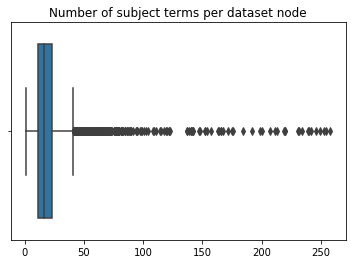

In [10]:
tmp = pd.DataFrame([['data_'+str(x),sub] for x,y in zip(all_data.data_set_id, all_data.subjects) for sub in y.split(',')], columns = ['data_name', 'sub'])
ax = sns.boxplot(tmp.groupby('data_name').size())
ax = ax.set_title('Number of subject terms per dataset node')

# 6. Load & Integrate Author

In [11]:
all_auth = pd.read_csv('data/p1p2_PubAuthor_pairs.csv')[['publication_id', 'AuthorId']]
all_auth = pd.concat([all_auth, pd.read_csv('data/PubAuthor_pairs.csv')[['publication_id', 'AuthorId']]]).reset_index(drop=True)
# display(all_auth[all_auth.publication_id == 5698], all_pubs[all_pubs.publication_id==5698])

In [12]:
auth_nodes = ['auth_'+str(i) for i in list(set(all_auth.AuthorId))]
auth_edges = [('pub_'+str(x),'auth_'+str(y)) for x,y in zip(all_auth.publication_id, all_auth.AuthorId)]

def addAuth(g):
    g.add_nodes_from(auth_nodes)
    g.add_edges_from(auth_edges)

addAuth(G)
print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())

Nodes 73438 
Edges 260720


# 7. Load & Integrate Publication Text Similarity Edges

In [13]:
all_sim = pd.read_csv('data/doc_sim.csv')[['Doc1', 'Doc2', 'Similarity']]

In [14]:
top_sim = all_sim[all_sim.Similarity >= 0.95]

sim_edges = [(x,y) for x,y in zip(top_sim.Doc1, top_sim.Doc2)]

def addPubSim(g):
    g.add_edges_from(sim_edges)
    
addPubSim(G)
    
print("Nodes", G.number_of_nodes(), "\nEdges", G.number_of_edges())
print("\nRatio of newly connected publications: ", len(set(top_sim.Doc1.append(top_sim.Doc2)))/all_pubs.shape[0])

Nodes 73438 
Edges 281084

Ratio of newly connected publications:  0.24231717885474302


# 8. Contract Similar Dataset Titles

In [15]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

months = ['january',
             'feburary',
             'march',
             'april',
             'may',
             'june',
             'july',
             'august',
             'september',
             'october',
             'november',
             'december']

roman = re.compile("""
    ^                   # beginning of string
    M{0,4}              # thousands - 0 to 4 M's
    (CM|CD|D?C{0,3})    # hundreds - 900 (CM), 400 (CD), 0-300 (0 to 3 C's),
                        #            or 500-800 (D, followed by 0 to 3 C's)
    (XC|XL|L?X{0,3})    # tens - 90 (XC), 40 (XL), 0-30 (0 to 3 X's),
                        #        or 50-80 (L, followed by 0 to 3 X's)
    (IX|IV|V?I{0,3})    # ones - 9 (IX), 4 (IV), 0-3 (0 to 3 I's),
                        #        or 5-8 (V, followed by 0 to 3 I's)
    $                   # end of string
    """ ,re.VERBOSE)
def remove_roman(sent):
    sent = word_tokenize(sent)
    sent = [i for i in sent if not roman.search(i)]
    sent = [i for i in sent if i not in months]
    return " ".join(sent)
def simplify_title(s):
    s = remove_roman(s)
    s = s.lower()
    s = re.sub("[^a-zA-Z]+", "", s)
    return s

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tanyanabila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df_datasets = all_data.copy()
df_datasets['data_name'] = ['data_'+str(i) for i in df_datasets.data_set_id]
df_datasets['title_unique'] = [simplify_title(i) for i in df_datasets.title]

titles = [simplify_title(i) for i in all_data.title]

df_titles = pd.DataFrame(set(titles)).reset_index()
df_titles.columns = ['title_id','title_unique']
df_titles.title_id = ['title_'+str(i) for i in df_titles.index]

print('Contracting nodes will reduce to:',df_titles.shape[0]/all_data.shape[0])

df_datasets = pd.merge(df_datasets, df_titles, on='title_unique', how='left')

contract = df_datasets.groupby('title_id')['data_name'].apply(list).reset_index()
contract['focal'] = [i[0] for i in contract.data_name]
contract['count'] = [len(i) for i in contract.data_name]
# contract = contract[contract['count'] > 1].reset_index(drop=True)

df_datasets = pd.merge(df_datasets, contract[['title_id', 'focal']], on='title_id', how='left')

Contracting nodes will reduce to: 0.5875531503672207


In [17]:
### Contraction will take hours! Don't run unless necessary
# G8 = G.copy()
# for idx,row in contract.iterrows():
#     print(idx, end='|')
#     for i in row.data_name[1:]:
#         G8 = nx.contracted_nodes(G8,row.focal, i)
# writeNX('data/network_v2.1.json', G8)

### Faster Route: Add from the beginning 
# df_datasets = pd.read_csv('data/df_datasets.csv')

focals = dict(zip(df_datasets.data_name,df_datasets.focal))

new_edges = [(x,focals[y]) for x,y in pub_edges]
new_data_nodes = list(set([focals[i] for i in data_nodes]))
new_sub_edges = [(focals[x], y) for x,y in sub_edges]

def startG():
    g = nx.Graph()
    g.add_nodes_from(pub_nodes+new_data_nodes)
    g.add_edges_from(new_edges)
    return g

def addST(g, edges=new_sub_edges):
    g.add_nodes_from(all_sub)
    g.add_edges_from(edges)

# 9. Load & Integrate Field of Study Entity

In [20]:
all_fos = pd.read_csv('data/allFoS_PubID.csv', dtype=object)
all_fos['pub_name'] = ['pub_'+str(i) for i in all_fos.publication_id]

In [25]:
fos_edges = [('pub_'+str(x),y) for x,y in zip(all_fos.publication_id, all_fos.NormalizedName)]

def addFoS(g):
    g.add_edges_from(fos_edges)
    
addFoS(G)

# 10. Load & Integrate Keyword - FoS Word2Vec Similarity

In [1]:
### Word2Vec Similarity scores were inconclusive. To be continued & Investigated